In [4]:
from tensorflow.keras import layers, Model, preprocessing
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.optimizers import Adam
from tensorflow.python.keras.layers import GlobalAveragePooling2D
import numpy as np
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
tf.config.list_physical_devices('GPU')

from utils import make_predictions, evaluation, data_loader

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

Num GPUs Available:  0


In [7]:
train_ds, val_ds, test_ds, class_names, image_size = data_loader.load_data(RANDOM_SEED, True, 0.75)

Found 15780 files belonging to 11 classes.
Using 11046 files for training.
Found 15780 files belonging to 11 classes.
Using 4734 files for validation.

Classes: ['tomato Fusarium Wilt', 'tomato spider mites', 'tomato verticillium wilt', 'tomato_bacterial_spot', 'tomato_early_blight', 'tomato_healthy_leaf', 'tomato_late_blight', 'tomato_leaf_curl', 'tomato_leaf_miner', 'tomato_leaf_mold', 'tomato_septoria_leaf']

✅ Balanced minority-only augmentation is ON

Counting class frequencies...
tomato Fusarium Wilt: 292
tomato spider mites: 456
tomato verticillium wilt: 376
tomato_bacterial_spot: 1201
tomato_early_blight: 1368
tomato_healthy_leaf: 1311
tomato_late_blight: 982
tomato_leaf_curl: 1335
tomato_leaf_miner: 1289
tomato_leaf_mold: 1342
tomato_septoria_leaf: 1094

Minority class: tomato Fusarium Wilt (count=292) → repeating 4× with augmentation

Minority class: tomato spider mites (count=456) → repeating 3× with augmentation

Minority class: tomato verticillium wilt (count=376) → repeat

In [8]:
denseNet121BaseArchitecture = DenseNet121(
    weights='imagenet',
    include_top=False,
    input_shape=(image_size[0], image_size[1], 3),
)

# Freeze early layers
denseNet121BaseArchitecture.trainable = True
for layer in denseNet121BaseArchitecture.layers:
    if layer.name == 'conv5_block1_0_bn':
        break
    layer.trainable = False

# Add proper classification head
x = denseNet121BaseArchitecture.output
x = layers.GlobalAveragePooling2D()(x)     
x = layers.Dense(256, activation='relu')(x)
predictions = layers.Dense(len(class_names), activation='softmax')(x)

denseNet121 = Model(inputs=denseNet121BaseArchitecture.input, outputs=predictions)

denseNet121.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

denseNet121.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                              

Epoch 1/10
425/425 [==============================] - 933s 2s/step - loss: 0.5423 - accuracy: 0.8308 - val_loss: 1.7094 - val_accuracy: 0.6626
Epoch 2/10
425/425 [==============================] - 755s 2s/step - loss: 0.1619 - accuracy: 0.9491 - val_loss: 1.1789 - val_accuracy: 0.7851
Epoch 3/10
425/425 [==============================] - 741s 2s/step - loss: 0.0913 - accuracy: 0.9711 - val_loss: 0.8650 - val_accuracy: 0.8606
Epoch 4/10
425/425 [==============================] - 773s 2s/step - loss: 0.0580 - accuracy: 0.9830 - val_loss: 0.7585 - val_accuracy: 0.8716
Epoch 5/10
425/425 [==============================] - 813s 2s/step - loss: 0.0442 - accuracy: 0.9872 - val_loss: 0.8140 - val_accuracy: 0.8788
Epoch 6/10
425/425 [==============================] - 788s 2s/step - loss: 0.0334 - accuracy: 0.9905 - val_loss: 0.7695 - val_accuracy: 0.8856
Epoch 7/10
425/425 [==============================] - 790s 2s/step - loss: 0.0284 - accuracy: 0.9918 - val_loss: 0.8991 - val_accuracy: 0.8771

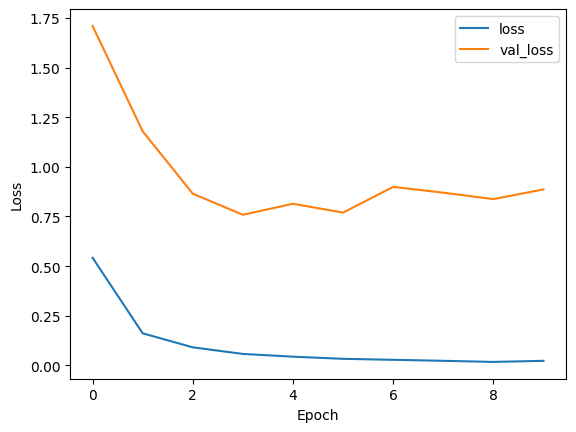

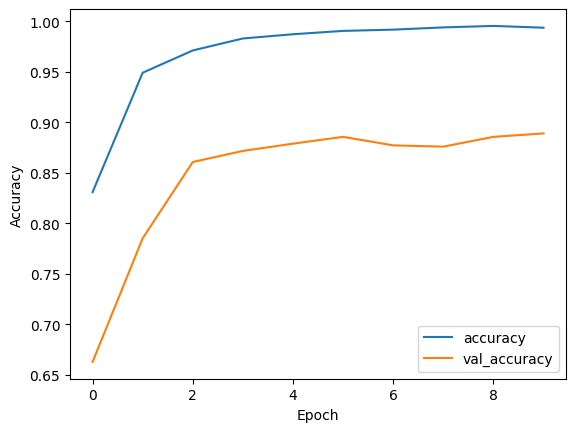

In [9]:
history = denseNet121.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10
)
evaluation.plot_loss(history)
evaluation.plot_accuracy(history)

In [10]:
y_true, y_pred = make_predictions.predict_test_data(denseNet121, test_ds)


1/1 [==============================] - 2s 2s/step


In [11]:
evaluation.make_classification_report(y_true, y_pred, class_names)

                          precision    recall  f1-score   support

    tomato Fusarium Wilt       1.00      0.78      0.88        55
     tomato spider mites       0.98      0.56      0.71        93
tomato verticillium wilt       0.91      0.93      0.92        69
   tomato_bacterial_spot       0.99      0.98      0.98       263
     tomato_early_blight       0.61      1.00      0.76       296
     tomato_healthy_leaf       0.97      0.96      0.97       284
      tomato_late_blight       1.00      0.05      0.10       227
        tomato_leaf_curl       0.89      1.00      0.94       271
       tomato_leaf_miner       0.97      0.98      0.97       299
        tomato_leaf_mold       0.90      1.00      0.94       284
    tomato_septoria_leaf       0.93      1.00      0.96       225

                accuracy                           0.87      2366
               macro avg       0.92      0.84      0.83      2366
            weighted avg       0.91      0.87      0.84      2366


Overal

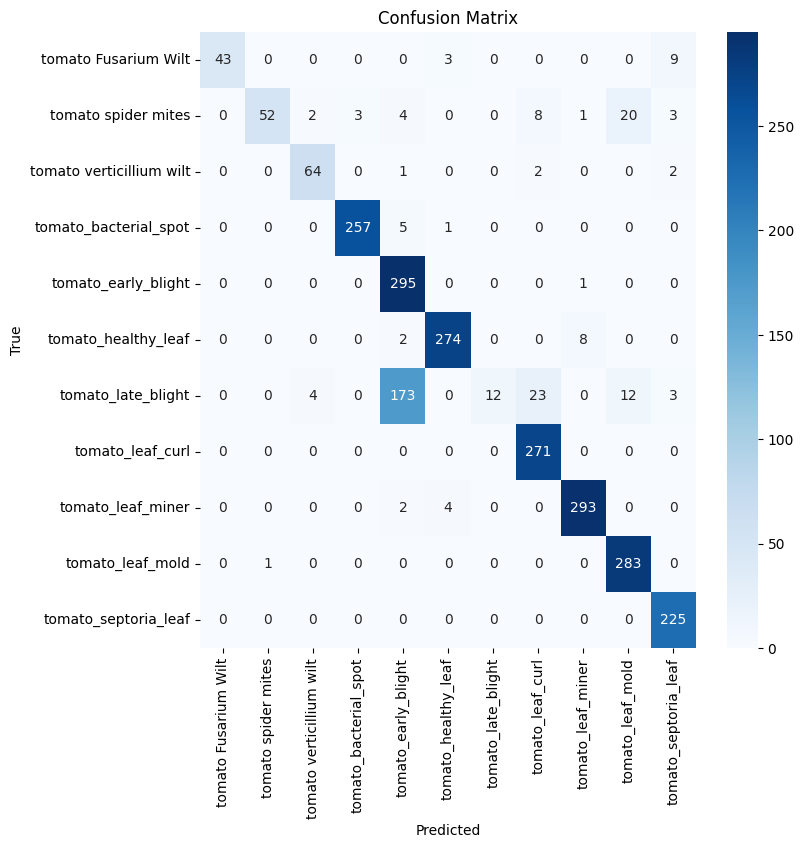

In [12]:
evaluation.make_confusion_matrix(y_true, y_pred, class_names)